# Sequential Lorentzian 

An example using the BayesOptExpt class to speed up measurements.

## Introduction

The OptBayesExpt package addresses the situation where we make measurements in order to determine the
parameters of model. This is the situation where we would traditionally make a series of measurements and then do fitting to extract the parameters.  The OptBayesExpt methods are especially handy for automated, routine measurements.

A weakness of the usual measure-then-fit approach is that the information accumulated during measurement
is not revealed until the fitting stage.  You don't learn much until the measurements are all
done.  Also, with measurement settings that are all preprogrammed, the measure-then-fit method
can waste time on unimportant measurements while 

In contrast, the OptBayesExpt class "learns" from each measurement result and then uses that
knowledge to suggest settings for the next measurement.  The "knowledge" is contained in a
probability distribution of model parameters.  The narrower the distribution, the better we
know the parameters. The "learning" process uses Bayes theorem to refine the probability
distribution based on each new measurement.

The benefits of this on-the-fly learning process are reaped when we use the accumulated
knowledge to guide the measurement process.  The learning allows us to make (partially) informed
decisions about measurement settings that are likely to be most useful.  What we mean by "useful"
here needs to be defined precisely, but the process can be sketched as follows.

What we (claim) we know about the world is that measurements will behave like our model, but we're
fuzzy on the model parameters, as described by their probability density.  Since the measurements
and the parameters are connected, if we allow the parameters to vary, the model will predict
correspondingly varying measurement values for fixed measurement settings.  Several lines of
information theory and Bayes theorem yield a very intuitive result: that the best measurement to
make next is the one that will pin down the model where it is varying the most.

## Set up OptBayesExpt

The OptBayesExpt package comes with no understanding of the measurements we want to make, and so it's our responsibility to teach the package about the measurements we want to do.  We'll educate our OptBayesExpt in two main stages, first describing the numerical ranges for experimental controls and model parameters and then adding our model of how the experiment operates.

First, we need an instance of the OptBayesExpt class that we can modify to suit our needs.  

In [1]:
from optbayesexpt import OptBayesExpt

myOBE = OptBayesExpt()

If you're not familiar with object oriented lingo, here's a translation: The OptBayesExpt class is like a bag of tools (methods, really) that know how to build and manipulate probability distribution functions, and tools that know how to recommend good measurement settings.  Our copy, `myOBE`, may be talented, but it's ignorant. We have to configure it by describing the experimental world that it will encounter.  

### Establish the Model

In this demonstration, the experimental model is a Lorentzian-shaped peak with a background.

$$ y(x) = B +\frac{A}{\left(\frac{x-x_0}{d}\right)^2 + 1}$$

As the experimenter varies the setting $x$, this model asserts that the measured values $y$ will trace out a Lorentzian curve centered a $x = x_0$ with a height $A$ relative to the background $B$, and a full-width at half-max of $2d$.

In [2]:
import numpy as np

def lorentz(x, x0, A, B, d):
    """
    Calculate a Lorentzian function of x
    All parameters may be scalars or they may be numpy arrays
        - as long as the arrays interact nicely
    :param x:  measurement setting
    :param A:  Amplitude parameter
    :param B:  background parameter
    :param d:  half-width at half-max parameter
    :param x0: peak center value parameter
    :return:  y  model output (float)
    """
    return B + A / (((x - x0) / d) ** 2 + 1)

Just for fun, here's a plot of this model function.

In [3]:
import matplotlib.pyplot as plt

x = np.linspace(0, 5, 100)
y = lorentz(x, 2.0, 2, 1, .2)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
 

Text(0,0.5,'y')

Before we move on, some words of caution are in order.  It's sort of a big deal to just boldly assert a model, because we're preparing to tell our deaf, dumb and blind bag of tools that the measurement data will reveal an external world that actually behaves like that model. What if there are two peaks? What if there is an asymmetrical peak or if the peak has more of a Gaussian shape?  

Next we have to connect this model to `myOBE`.  Internally, `OptBayesExpt` requires a model function that it can call with three arguments:

1. `setings` -- a tuple containing experimental settings, i.e. your experimental knobs.   Just (`x`,) in this case.
2. `parameters` -- a tuple containing model parameters, (`x0`, `A`, `B`) in this case for the peak center, peak height and background.
3. `constants` -- a tuple containing constants.  In this case, just (`d`,) the peak width parameter.

These arguments are discussed in more detail [below](#Mark-out-numerical-ranges).

In [4]:
def my_model_function(settings, parameters, constants):
        # unpack the experimental settings
        x = settings[0]
        # unpack model parameters from pars tuple.  Order is important.
        x0 = parameters[0]
        A = parameters[1]
        B = parameters[2]
        # unpack model constants
        d = constants[0]
        return lorentz(x, x0, A, B, d)

myOBE.model_function = my_model_function


The `my_model_function` below doesn't really do much computation.  It's just a wrapper that allows the `lorentz` model to be evaluated using the required `sets, pars, cons` arguments.

The definition of `myOBE.model_function` connects our model to the `myOBE` instance of `OptBayesExpt`.

### Mark out numerical ranges

The next step is to include what we think reasonable settings and model parameters are and what the constant values should be.

#### Settings

Settings are the experimental control knobs.  Here, we have one knob, _x_ and we will allow our `myBOE` to make measurements at any setting in a 200-member array that runs from 1.5 to 4.5.  Int the experiment that inspired this example, we expect to see a resonance near 3 GHz and it could be anywhere within 1.5 GHz on either side.  We know in advance that the resonance is 200 MHz wide.  If we use 100 possible settings, we'll have a resolution of 30 MHz, which should allow several possible settings within the center of the peak.  We create a 100-member array, pack it into a 1-element tuple, and configure the settings.

In [5]:
xvals = np.linspace(1.5, 4.5, 100)
myOBE.sets = (xvals,)

#### Parameters

Parameters are properties of the system that's being measured.  This is where we declare what's reasonable for the parameter values, and we provide information how to discretize parameter space. 

First off, we think that the peak center $x_0$ should be between 2 and 4 and we'd be content with a resolution of 0.01.

In [6]:
x0min = 2
x0max = 4
x0vals = np.linspace(x0min, x0max, 201)

We think that the peak amplitude should be between -2000 and -10000.  Negative numbers indicate that we're sure it's actually going to be a dip relative to the background instead of a peak.

In [7]:
Amin = -2000
Amax = -10000
Avals = np.linspace(Amin, Amax, 101)

Our final parameter is the background value.  We think it should be between 275000 and 225000.

In [8]:
Bmin = 275000
Bmax = 225000
Bvals = np.linspace(Bmin, Bmax, 151)

We take these arrays, package them as a tuple and configure the parameters.  Note that the order corresponds to how the parameters are unpacked in the `model_function`.

In [9]:
myOBE.pars = (x0vals, Avals, Bvals)

#### Constants

And the lone constant, the one thing that we're sure about, the width parameter as a 1-element tuple.

In [10]:
dtrue = .1
myOBE.cons = (dtrue,)

In the next step, we configure `myBOE` using the arrays we assigned to `myBOE.sets`, `myBOE.pars` and `myBOE.cons`.  Several significant things happen.  If `myBOE.pars` is an _N_-element tuple of arrays, the probability density is set up as an _N_-dimensional array with dimensions corresponding the sizes of the arrays.  In this example, a 3D array with dimensions of (201, 101, 151).  It's easy to set up too many fit parameters or too much discretization.  Don't be greedy. Additionally, the `config()` method initializes a default uniform probability density, which amounts to a uniform Bayesian prior.  Essentially the default  declares that each parameter is equally likely to occur anywhere in its declared range, and that if the 'true' value is outside that range, we're prepared to live with the consequences.  If we have some expert knowledge, say from previous measurements, it can be included using `myBOE.setPDF()` or `myBOE.setlnPDF()`, but this is supposed to be the simple example.

In [11]:
myOBE.config()

That's it.  `myBOE` is all set up and ready to go.

## Simulate Measurement

For demonstration purposes we're going to fake a noise measurement that evaluates a Lorentzian with secretly determined parameter values.  So we generate some random values for the parameters and swear on a copy of Abramowitz and Stegun that we're going to keep the values secret and let `myBOE` discover them.

In [12]:
x0true = (x0max - x0min) * np.random.rand() + x0min  # pick a random resonance x0
Btrue = (Bmax - Bmin) * np.random.rand() + Bmin  # pick a random background
Atrue = (Amax - Amin) * np.random.rand() + Amin  # pick a random amplitude

The constant `dtrue` is a "known" constant and we borrow it from the `myBOE.cons` assignment above.  The simulated measurement results are generated using the `simdata()` routine.

In [13]:
def simdata(x):
    """
    simulate a measurement at x
    :param x:  measurement setting
    """
    # calculate the theoretical output result
    y = lorentz(x, x0true, Atrue, Btrue, dtrue)
    # add 2% noise from a normal distribution
    s = 0.02 * y

    if type(x) == np.ndarray:
        y += s * np.random.randn(len(x))
    else:
        y += s * np.random.randn()
    return y

## Set up the demo

The hard work of describing the world to our program is now complete, and it's time to play.  Most of the lines in the `batchdemo` code below serve to set up and display plots, but that's not what we're trying to demonstrate.  The crucial lines in the "measurement" cycle are:
* `reply = myBOE.opt_setting()`  
   In this line, `myBOE` uses the accumulated measurements to suggest the experimental setting that should have greatest effect narrowing the parameter distribution.  The `reply` is a tuple to accommodate experiments with multiple controls.
*  `reply = myOBE.good_setting(pickiness=pickiness)`  
   This line is similar, but instead of choosing the absolute best predicted setting, the routine picks a random setting, weighted by the usefulness.  The `pickiness` value controls how much the weighting is skewed toward the most useful settings.  `Pickiness` values > 10 behave similarly to `myOBE.opt_setting()`.  
*  `ymeasure = simdata(xmeasure)`  
   is our simulated substitute for an actual measurement.  
*  `myOBE.pdf_update((xmeasure,) ymeasure, 0.02*ymeasure)`  
   In this line, the measurement results are reported back to `myOBE` as a settings tuple, a single measured value and an uncertainty.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def batchdemo():
    global Nmeasure
    global pickiness
    global optimum
    
    xdata = np.zeros(Nmeasure)
    ydata = np.zeros(Nmeasure)
    sig = np.zeros(Nmeasure)
    myOBE.set_pdf(flat=True)
    for i in np.arange(Nmeasure):
        """ get the recommended measurement seting """
        if optimum:
            reply = myOBE.opt_setting()
        else:
            reply = myOBE.good_setting(pickiness=pickiness)

        xmeasure = reply[0]
        """ make a simulated measurement """
        ymeasure = simdata(xmeasure)
        xdata[i] = xmeasure
        ydata[i] = ymeasure

        """digest the results -- the learning phase"""
        myOBE.pdf_update((xmeasure,), ymeasure, 0.02 * ymeasure)
        # get statistics to track progress
        sig[i] = myOBE.get_std(0)

    plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.plot(xdata, ydata, '.')
    plt.plot(xvals, lorentz(xvals, x0true, Atrue, Btrue, dtrue))
    plt.xlabel("x")
    plt.ylabel("y")

    plt.subplot(132)
    plt.plot(xdata, '.')
    plt.xlabel("Measurement number")
    plt.ylabel("x setting value")


    plt.subplot(133)
    plt.semilogy(sig)
    resolution = (xvals[1]-xvals[0])
    plt.arrow(20,resolution, -20, 0)
    plt.text(20,resolution, "x0 resolution")
    plt.ylabel("sigma x0")
    plt.xlabel("Measurement number")
    plt.tight_layout()


## Run the demo

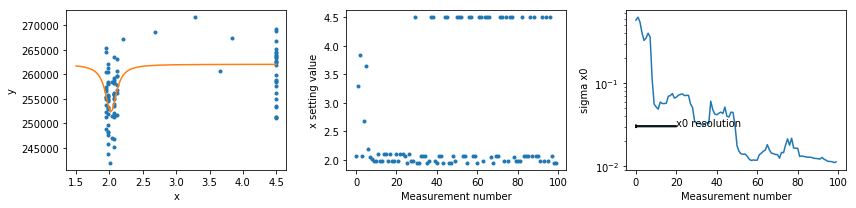

In [15]:
Nmeasure = 100
pickiness = 4
optimum = True

batchdemo()

The left plot shows the "true" curve and the simulated measurement data.  The plot in the center shows the sequence of measurement settings recommended by `myBOE` demonstrating how the OptBayesExpt methods concentrate measurements around the peak. If `optimum = True`, `myOBE.opt_setting()` is used, and there will be a concentration of measurements at one extreme setting, which is the best place to measure the background $B$.  If`myOBE.good_setting()` is used.  The right plot shows the standard deviation of the probability distribution of the peak's center point.  Typical behavior includes a searching phase while enough measurements are made to locate the peak.  The uncertainty then drops rapidly as the measurements focus on the peak region.  Standard deviation (sigma) values close to or less than the x0 resolution aren't very meaningful.  It's a sign that the method has been so successful that the discretization we set up in the parameters section has failed.